In [4]:
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair
from ATARI.models.experimental_model import Experimental_Model


In [5]:
%matplotlib widget

# Define generative models

Neutron induced reaction measurements using the time-of-flight method can be modelled using 3 primary categories:
1. A reaction model, represented here in ATARI the Particle_Pair class
2. An experimental model, represented here in ATARI by the Experimental_Model class
3. A reduction model, represented in ATARI by a Reduction_Model protocol

These three models attempt to describe everything that is happenning in one of these experiments. 
Traditionally, these models are used to analyze experimental data. 
The Syndat module of the ATARI code uses these models in a generative manner, producing statistical samples of experimental data.

The Generative_Model class is a container for the above three models that will be used to generate data.
This class can be instantiated with defaults, or each of the respective models can be supplied individually.
The following code snippet shows how these models can be created and manipulated from the defaults in the Generative Model container.

In [6]:
# # take default values and inspect each

# generative_model_1 = Generative_Model()

# print("Particle Pair Model:\n")
# print(generative_model_1.particle_pair)

# print()
# print("Experimental Model Sammy Inputs:")
# print(generative_model_1.experimental_model.sammy_inputs)

# print()
# print("Experimental Model Sammy Inputs Altered:")
# generative_model_1.experimental_model.sammy_inputs = {'alphanumeric': ["BROADENING IS NOT WANTED"],
#                                                       'ResFunc' : ''}
# print(generative_model_1.experimental_model.sammy_inputs)


# print()
# print("Reduction Model:")
# print(generative_model_1._reduction_model)

## Reaction Model: Particle Pair class
Each of the 3 models can also be created outside and then added to the Generative Model container.
These ATARI classes have additional functionality if you want to work with them at this lower level.
The following code snippet demonstrates some of these capabilities.

In [7]:
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        ac = 8.127,
                        M = 180.94803,
                        I = 3,
                        l_max = 2
)

# print quant number map up to l_max
Ta_pair.map_quantum_numbers(print_out=True)

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)
Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

print()
print("Interrogate spin group attribute:")
print(Ta_pair.spin_groups['3.0'])


print()
print("Resonance ladder sampled from resonance statistics:")
print(Ta_pair.sample_resonance_ladder(energy_range=[200, 250]))

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-4.5, 1, [1])
(-3.5, 2, [1, 1])
(-2.5, 2, [1, 1])
(-1.5, 1, [1])
(0.5, 1, [2])
(1.5, 2, [2, 2])
(2.5, 3, [0, 2, 2])
(3.5, 3, [0, 2, 2])
(4.5, 2, [2, 2])
(5.5, 1, [2])

Interrogate spin group attribute:
{'J_ID': 1, '<D>': 8.79, '<Gn>': 46.5, 'n_dof': 1, '<Gg>': 64.0, 'g_dof': 1000, 'D01': 0.9943384234177864, 'D99': 21.284662911191237, 'Gn01': 0.007304585392801135, 'Gn99': 308.52269194748646, 'Gg01': 57.53039660349525, 'Gg99': 70.84601563854191, 'Gt01': 57.53770118888805, 'Gt99': 379.3687075860284}

Resonance ladder sampled from resonance statistics:
             E         Gg         Gn1    J J_ID varyE varyGg varyGn1
0   204.217552  59.114296   23.799701  3.0    1   0.0    0.0     0.0
1   212.689479  67.408509    7.421523  3.0    1   0.0    0.0     0.0
2   229.494556  64.233957   55.420692  3.0    1   0.0    0.0     0.0
3   233.731644  69.015657    42.43948  3.0    1   0.0    0.0     0.0
4   239.723443  65.522316   32.791766  3.0    1

## Experimental Model class & Sammy

This class's primary purpose is to hold relevant experimental information used in calculating experimentally corrected resonance models with SAMMY.
The ATARI code come with a sammy-interface module that wraps around the sammy code. For more details on this interface, see the user example notebook. 
Before the Experimental_Model can be passed to syndat, the user must define the template parameter to be a path to a sammy input template. 

The sammy interface has a module for creating template input files from these generative models. 
The idea is that you make the template, inspect it manually, then give it to the experimental model class to be used with syndat

In [8]:

exp_trans12 = Experimental_Model(title = "T12mm", 
                                 reaction = "transmission", 
                                 energy_range = [200, 250], 
                                 template = None, 
                                 energy_grid = None, 
                                 n = (0.067166, 0.0), 
                                 FP = (35.185, 0.0), 
                                 t0 = (3326.0, 0.0), 
                                 burst = (10, 1.0), 
                                 temp = (300, 0.0), 
                                 channel_widths = { 
                                     "maxE": [250],
                                     "chw": [100.0],
                                     "dchw": [0.8]
                                 }
)


sammy_rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T.inp', Ta_pair, exp_trans12, sammy_rto)


exp_trans12.template = os.path.realpath('template_T.inp')

## Measurement models

Syndat needs both a generative and reductive measurement model. 
The generative model is considered 'true' and is used to generate statistical samples of raw experimental observables. 
These raw observables, however, are not used directly in evaluations, rather they are put through a data reduction model to get an object like experimental transmission or capture yield. 
By defining both a generative and reductive measurment model, Syndat can be used to investigate the impact of incorrectly specified measurement models/parameters used in the data reduction process.



In [9]:
from ATARI.models.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import syndat, syndatOPT


generative = Transmission_RPI()
reductive = Transmission_RPI()

## Sampling from Syndat

The syndat class contains all necessary model information. 
It also takes a syndat options class which can be instantiated with default settings.
Once you've constructed your syndat model, the sample method can be used to draw any number of samples.
This method takes either a sammyRTO arguement or a pw_true arguement. 
If pw_true is given, this will be taken as the true experimental function around with measurement data will be sampled. 
Usually the user will provide a sammyRTO instead which will allow the true experimental function to be reconstructed by sammy.
This also allows new resonance ladders to be sampled each time.


In [12]:
synOPT = syndatOPT()
synOPT

calculate_covariance: False
sampleRES: True
sampleTNCS: True
sampleTURP: True
sample_counting_noise: True
save_raw_data: False
smoothTNCS: False

In [13]:
synT = syndat(Ta_pair,
              exp_trans12,
              generative,
              reductive,
              synOPT)

synT.sample(sammyRTO=sammy_rto, num_samples=5)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'


In [14]:
### capture data info
# 'n'         :   (0.067166,            0),
# 'FP'        :   (35.185,              0),
# 't0'        :   (3.326,               0),
# 'bw'        :   (0.0064,              0),

# exp_model_Y = experimental_model("Y1mm", "capture", [200,250],
                               
#                                     parameters={
#                                         'FP':(100.14,0.01),
#                                         't0':(2.0, 0.0)
#                                         } ,

#                                     channel_width_info={
#                                           "maxE": [500], 
#                                           "chw": [100.0],
#                                           "dchw": [0.8]
#                                           }
#                                                                   )

# exp_model_Y

# Plot

In [15]:
data = synT.datasets[0].pw_reduced
data

,tof,E,true,exp,exp_unc
0,183110.960936,200.200037,0.443391,0.475353,0.022889
1,183010.960948,200.422933,0.297208,0.322284,0.017103
2,182910.960963,200.646202,0.156498,0.164342,0.010678
3,182810.960863,200.869845,0.093679,0.102068,0.007909
4,182710.960904,201.093861,0.098298,0.120102,0.008901
...,...,...,...,...,...
184,164710.960895,248.453308,0.043395,0.047749,0.005115
185,164610.960907,248.761496,0.053109,0.052317,0.005427
186,164510.960956,249.070258,0.062783,0.058228,0.005800
187,164410.960913,249.379595,0.065751,0.060520,0.006062


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


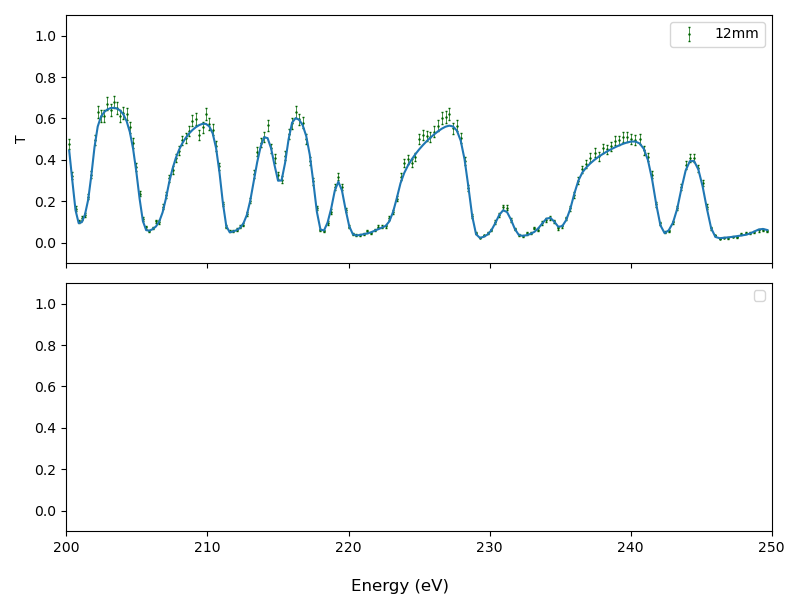

In [16]:
### Plot 

fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

### Trans
axes[0].errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

axes[0].plot(data.E, data.true)
axes[0].set_ylabel("T")

# ### Capture
# axes[1].errorbar(synY.data.E, synY.data.exp, yerr=synY.data.exp_unc, zorder=0, 
#                                         fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='1mm')
# axes[1].plot(synY.data.E, synY.data.true)

# axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,250])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

# Investigate Noise Distribution : need to update this

In [32]:

# jb_df = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_reduction_data.csv", index_col='Unnamed: 0')
# jb_cov = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_cov.npy")
# jb_sys = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_syst.npy")
# jb_stat = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_stat.npy")
# jb_df['bw'] = jb_df.bw*1e-6
# realdat = jb_df.loc[(jb_df.e < 120) & (jb_df.e > 3)]


# transdat12 = sammy_functions.readlst(
#     "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
# exptrans12 = Experimental_Model(title="trans12mm",
#                                 reaction="transmission",
#                                 energy_range=[2, 120],

#                                 sammy_inputs={
#                                     'alphanumeric':   ["BROADENING IS WANTED"],
#                                     'ResFunc':   "ORRES"
#                                 },

#                                 n= (0.067166, 0.0),
#                                 FP= (35.185, 0.0),
#                                 burst= (8, 0.0),
#                                 temp= (294.2610, 0.0),

#                                 channel_width_info={
#                                     "maxE": [270],
#                                     "chw": [102.7],
#                                     "dchw": [0.8]
#                                 },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000",
#                                                           "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                 )

# transdat12 = transdat12[(transdat12.E < max(exptrans12.energy_range)) & (
#     transdat12.E > min(exptrans12.energy_range))]

In [33]:
# from syndat.old.control import syndat
# from ATARI.models.Y_reduction_rpi import yield_rpi
# from ATARI.models.T_reduction_rpi import transmission_rpi

# fit from jeff


# sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
#                                              {"Print":   True,
#                                               "bayes":   False,
#                                               "keep_runDIR": False
#                                               })

# matnum = 7328
# jeff_file = "/Users/noahwalton/research_local/data/JEFF33_endf6/73-Ta-181g.jeff33"
# jeff_parameters = sammy_functions.get_endf_parameters(
#     jeff_file, matnum, sammyRTO)

# jeff_parameters = jeff_parameters[(
#     jeff_parameters.E < 120) & (jeff_parameters.E > 2)]
# jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))*1
# jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
# jeff_parameters["varyE"] = np.ones(len(jeff_parameters))*1


# datasets = [transdat12]
# experiments = [exptrans12]
# # templates = [os.path.realpath('template_T.inp')]
# templates = []
# for data, exp in zip(datasets, experiments):
#     filepath = f'template_{exp.title}'
#     # templates are already made and edited!
#     template_creator.make_input_template(filepath, model, exp, rto)
#     templates.append(os.path.realpath(filepath))

# sammyINPyw = sammy_classes.SammyInputDataYW(
#     particle_pair=Ta_pair,
#     model=model,
#     resonance_ladder=jeff_parameters,

#     datasets=datasets,
#     templates=templates,
#     experiments=experiments,

#     max_steps=20,
#     iterations=2,
#     step_threshold=0.01,
#     autoelim_threshold=None,

#     LS=False,
#     LevMar=True,
#     LevMarV=1.5,
#     # LevMarVd=5,
#     initial_parameter_uncertainty=0.1
# )

# sammyRTO.bayes = True
# sammyRTO.keep_runDIR = True
# sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

### Randomly sampled resonances ladders
Usually produces a similar signal to noise ratio unless the resonance ladder is drastically different, could look at average over many repetitions? Want to match 

In [34]:

# sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
#                                              {"Print":   True,
#                                               "bayes":   False,
#                                               "keep_runDIR": False
#                                               })


# datasets = [transdat12]
# experiments = [exptrans12]
# # templates = [os.path.realpath('template_T.inp')]
# templates = []
# for data, exp in zip(datasets, experiments):
#     filepath = f'template_{exp.title}'
#     template_creator.make_input_template(filepath, Ta_pair, exp, rto)
#     templates.append(os.path.realpath(filepath))

# res = Ta_pair.sample_resonance_ladder([2,120])

# sammyINPyw = sammy_classes.SammyInputDataYW(
#     particle_pair=Ta_pair,
#     resonance_ladder=res,

#     datasets=datasets,
#     templates=templates,
#     experiments=experiments,
# )

# sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

In [35]:

# true_df = copy(sammyOUT.pw[0])
# assert (isinstance(true_df, pd.DataFrame))
# true_df = true_df[["E", "theo_trans"]]
# true_df.rename(columns={"theo_trans": "true"}, inplace=True)


# generation_T1 = transmission_rpi(reduction_parameters={'trigo':   (9758727,             0),
#                                                        'trigs':   (18476117,            0)}
#                                                        )
# reduction_T1 = transmission_rpi(reduction_parameters={'trigo':   (9758727,             0),
#                                                       'trigs':   (18476117,            0)}
#                                                       )

# synT = syndat(options={})
# synT.(true_df, generation_T1, reduction_T1, exp_model_T)

In [36]:
# figure()
# plot(transdat12.E, transdat12.exp, 'k.', markersize=1)
# plot(synT.data.E, synT.data.exp, 'b.', markersize=1)
# # plot(synT.data.E, synT.data.true, 'b', markersize=1)
# ylim([-0.1,1])

In [20]:

# freq = np.fft.fftfreq(len(synT.data.tof), synT.data.tof[1] - synT.data.tof[0])

# Y = np.fft.fft(transdat12.exp)

# Ysyn = np.fft.fft(synT.data.exp)
# # P_signal = np.abs(Ysyn)**2
# # P_noise = np.abs(Y[noise_indices])**2
# # SNR = np.sum(P_signal) / np.sum(P_noise)

# figure()
# plot(freq, abs(Y), 'k.')
# plot(freq, abs(Ysyn), 'b.')
# ylim(-0.01, 100)
# xlim(0)

# # xscale('log')
# # yscale('log')